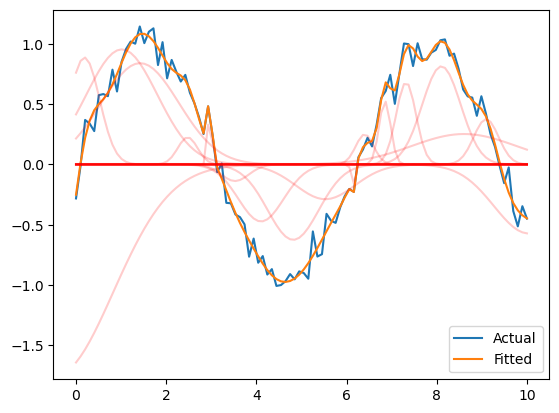

In [3]:
import numpy as np
from scipy.optimize import minimize

# Sample time series data
time = np.linspace(0, 10, 100)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))

# Initial guess for Gaussian parameters
n_gaussians = 20
initial_means = np.linspace(time.min(), time.max(), n_gaussians)
initial_sigmas = np.full(n_gaussians, 1.0)
initial_amplitudes = np.full(n_gaussians, 1.0)
initial_params = np.concatenate([initial_means, initial_sigmas, initial_amplitudes])

# Gaussian function
def gaussian(t, mu, sigma, A):
    return A * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Sum of Gaussians
def sum_of_gaussians(params, t):
    means = params[:n_gaussians]
    sigmas = params[n_gaussians:2*n_gaussians]
    amplitudes = params[2*n_gaussians:]
    return sum(gaussian(t, mu, sigma, A) for mu, sigma, A in zip(means, sigmas, amplitudes))

# Loss function
def loss(params):
    fitted = sum_of_gaussians(params, time)
    return np.mean((data - fitted) ** 2)

# Optimize parameters
result = minimize(loss, initial_params, method='L-BFGS-B')
optimized_params = result.x

# Inference
fitted_data = sum_of_gaussians(optimized_params, time)

# Plot results
import matplotlib.pyplot as plt

plt.plot(time, data, label='Actual')
plt.plot(time, fitted_data, label='Fitted')
for mean, sigma, amplitude in zip(optimized_params[0:n_gaussians], optimized_params[n_gaussians:2*n_gaussians], optimized_params[2*n_gaussians:]):
    plt.plot(time, gaussian(time, mean, sigma, amplitude), color='red', alpha=0.2)
plt.legend()
plt.show()


In [116]:
# Variables:
signal_length = 500
train_percentage = 0.80
n_gaussians = 100

Using device: cuda:3
initial means [109 137  29  53 315 116 236  62 287  78 172   1  82 437 191  84 403 429
 203 228 377 420  61 373 184  10  98 158 251 475 105 349 485 408 487 253
 197 488 442 166 384 160 495 174  83 353  35 381 150  88  79 438  66 249
 188 388 204 258 226 370 288 233  18 345 372 441  54 362 341  34 256  75
 473 467 472 317 132 144  36  45 245 230 324  57 244 202 180  85 201 213
 328  67 327 130 164 338 295 171 448 238]


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:05<00:00, 39.85it/s, loss=0.0654]


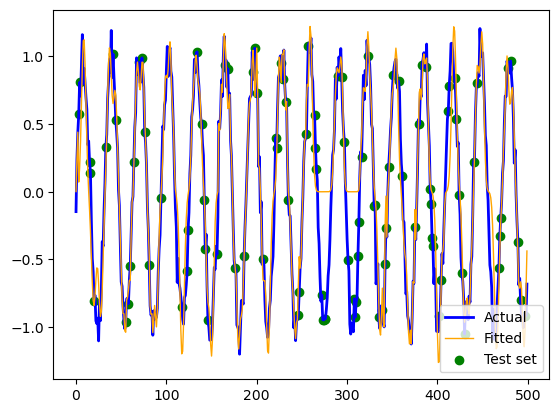

In [123]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Check if CUDA is available and set the device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# device = torch.device('cpu')
# print(f'Using device: {device}')
# create array from 0 to signal lenght, step 1
time = np.arange(0, signal_length, 1)
data = np.sin(time*0.2) + np.random.normal(0, 0.1, signal_length)

# split data into training and testing
time_train, time_test, data_train, data_test = train_test_split(time, data, train_size=train_percentage, shuffle=True)

time_tensor = torch.tensor(time, dtype=torch.float32, device=device)
data_tensor = torch.tensor(data, dtype=torch.float32, device=device)


# uniformly sample n_gaussians from the time_train array
train_samples = len(time_train)
initial_indexes = np.linspace(0, train_samples-1, n_gaussians).astype(int)
initial_means = time_train[initial_indexes]
print( f"initial means {initial_means}")

initial_sigmas = np.full(n_gaussians, 1.0)
# amplitudes are the values of the data at the means
initial_amplitudes = np.array([data[mean] for mean in initial_means])

# Convert initial parameters to PyTorch tensors and move to device
means = torch.tensor(initial_means, dtype=torch.float32, requires_grad=True, device=device)
sigmas = torch.tensor(initial_sigmas, dtype=torch.float32, requires_grad=True, device=device)
amplitudes = torch.tensor(initial_amplitudes, dtype=torch.float32, requires_grad=True, device=device)

# Gaussian function
def gaussian(t, mu, sigma, A):
    return A * torch.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Sum of Gaussians
def sum_of_gaussians(t, means, sigmas, amplitudes):
    gaussians = [gaussian(t, mu, sigma, A) for mu, sigma, A in zip(means, sigmas, amplitudes)]
    return torch.sum(torch.stack(gaussians), dim=0)

# Loss function
def loss(means, sigmas, amplitudes, time, data):
    fitted = sum_of_gaussians(time, means, sigmas, amplitudes)
    return torch.mean((data - fitted) ** 2)


# Convert time and data to PyTorch tensors and move to device
time_train_tensor = torch.tensor(time_train, dtype=torch.float32, device=device)
data_train_tensor = torch.tensor(data_train, dtype=torch.float32, device=device)

# Optimizer
optimizer = torch.optim.Adam([means, sigmas, amplitudes], lr=3e-4)

# Optimization step
def closure():
    optimizer.zero_grad()
    l = loss(means, sigmas, amplitudes, time_train_tensor, data_train_tensor)
    l.backward()
    return l

# run with tqdm and show loss
with tqdm(range(5000)) as pbar:
    for i in pbar:
        optimizer.step(closure)
        l = loss(means, sigmas, amplitudes, time_tensor, data_tensor)
        pbar.set_postfix({'loss': l.item()})


# Extract optimized parameters
optimized_means = means.detach().cpu().numpy()
optimized_sigmas = sigmas.detach().cpu().numpy()
optimized_amplitudes = amplitudes.detach().cpu().numpy()

# Inference
time_tensor = torch.tensor(time, dtype=torch.float32, device=device)
fitted_data = sum_of_gaussians(time_tensor, means, sigmas, amplitudes).detach().cpu().numpy()


# Plot results
plt.plot(time, data, label='Actual', color='blue', linewidth=2)
plt.plot(time, fitted_data, label='Fitted', color='orange', linewidth=1)
# for mean, sigma, amplitude in zip(optimized_means, optimized_sigmas, optimized_amplitudes):
#     plt.plot(time, gaussian(time_tensor, mean, sigma, amplitude).detach().cpu().numpy(), color='red', alpha=0.1)
# print test set
plt.scatter(time_test, data_test, color='green', label='Test set')
plt.legend()
plt.show()



In [115]:
print(f"optimized means {optimized_means}")
print(f"optimized sigmas {optimized_sigmas}")
print(f"optimized amplitudes {optimized_amplitudes}")

optimized means [ 28.265703  243.167     337.9153     81.914734  432.47516   275.2011
  88.2838    322.9059    132.6571    280.90005   474.58102   354.883
 305.12726   239.32916   456.50397   169.5454    302.12335   264.70688
 383.04822   212.49814    68.59674   315.46127   458.49017    84.8175
  23.880703  245.25952   307.39636   257.45102   484.65802   116.05947
  17.391674   74.801506    2.2825234 122.986496  182.83945   321.2843
 461.94537   100.5044    403.45895    41.42375   269.41238    58.38825
 105.90369   128.09494   406.0963    345.81757   407.43002   194.08437
 482.34256    54.289898  121.0318    190.98357    49.952606   13.180643
 292.8708    146.70108   303.81625   438.50537   137.1462    367.66998
 186.33682   350.09866   360.63242   198.63858   387.60065    77.08806
  41.52509   480.2877    416.67612   284.32675   460.26297   492.5871
 255.81104   260.12076     3.358299  247.59344   118.26334   300.05557
 329.78345   318.63385   447.265     448.53445   478.4973    178.5

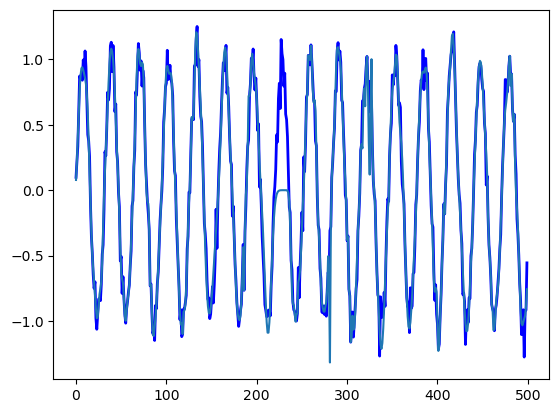

In [114]:
plt.plot(time, data, label='Actual', color='blue', linewidth=2)
plt.plot(time, fitted_data, label='Fitted')

In [132]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Check if CUDA is available and set the device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
device = torch.device('cpu')
print(f'Using device: {device}')

# Sample time series data
signal_length = 1000
train_percentage = 0.8
time = np.arange(0, signal_length, 1)
data = np.sin(time * 0.2) + np.random.normal(0, 0.1, signal_length)

# Split data into training and testing
time_train, time_test, data_train, data_test = train_test_split(time, data, train_size=train_percentage, shuffle=True)

# Number of Gaussians
n_gaussians = 20

# Uniformly sample n_gaussians from the time_train array
train_samples = len(time_train)
initial_indexes = np.linspace(0, train_samples - 1, n_gaussians).astype(int)
initial_means = time_train[initial_indexes]
print(f"initial means {initial_means}")

initial_sigmas = np.full(n_gaussians, 1.0)
initial_amplitudes = np.array([data[mean] for mean in initial_means])

# Convert initial parameters to PyTorch tensors and move to device
means = torch.tensor(initial_means, dtype=torch.float32, requires_grad=True, device=device)
sigmas = torch.tensor(initial_sigmas, dtype=torch.float32, requires_grad=True, device=device)
amplitudes = torch.tensor(initial_amplitudes, dtype=torch.float32, requires_grad=True, device=device)

# Gaussian function
def gaussian(t, mu, sigma, A):
    return A * torch.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Sum of Gaussians
def sum_of_gaussians(t, means, sigmas, amplitudes):
    gaussians = [gaussian(t, mu, sigma, A) for mu, sigma, A in zip(means, sigmas, amplitudes)]
    return torch.sum(torch.stack(gaussians), dim=0)

# Loss function
def loss(means, sigmas, amplitudes, time, data):
    fitted = sum_of_gaussians(time, means, sigmas, amplitudes)
    return torch.mean((data - fitted) ** 2)

# Convert time and data to PyTorch tensors and move to device
time_train_tensor = torch.tensor(time_train, dtype=torch.float32, device=device)
data_train_tensor = torch.tensor(data_train, dtype=torch.float32, device=device)

# Optimizer
optimizer = torch.optim.Adam([means, sigmas, amplitudes], lr=3e-4)

# Thresholds for splitting/cloning/removal
large_grad_threshold = 1.0
small_amplitude_threshold = 0.001
large_amplitude_threshold = 10.0
low_alpha_threshold = 0.001

# Run optimization with tqdm and show loss
with tqdm(range(5000)) as pbar:
    for i in pbar:
        def closure():
            optimizer.zero_grad()
            l = loss(means, sigmas, amplitudes, time_train_tensor, data_train_tensor)
            l.backward()
            return l
        
        l = loss(means, sigmas, amplitudes, time_train_tensor, data_train_tensor)
        optimizer.step(closure)

    
        #run every 100 iterations:
        if i % 505 == 0:
            # Check gradients and amplitudes
            means_grad = means.grad.abs().cpu().numpy()
            sigmas_grad = sigmas.grad.abs().cpu().numpy()
            amplitudes_grad = amplitudes.grad.abs().cpu().numpy()
            # Split, clone, or remove Gaussians based on criteria
            new_means = []
            new_sigmas = []
            new_amplitudes = []
            for j in range(len(means)):
                if means_grad[j] > large_grad_threshold:
                    # Split Gaussian
                    new_means.append(means[j].item() + 0.1 * np.random.randn())
                    new_means.append(means[j].item() - 0.1 * np.random.randn())
                    new_sigmas.append(sigmas[j].item())
                    new_sigmas.append(sigmas[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                elif amplitudes[j].item() < small_amplitude_threshold:
                    # Clone Gaussian
                    new_means.append(means[j].item())
                    new_sigmas.append(sigmas[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                    new_means.append(means[j].item())
                    new_sigmas.append(sigmas[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                elif amplitudes[j].item() > large_amplitude_threshold:
                    # Split Gaussian
                    new_means.append(means[j].item() + 0.1 * np.random.randn())
                    new_means.append(means[j].item() - 0.1 * np.random.randn())
                    new_sigmas.append(sigmas[j].item())
                    new_sigmas.append(sigmas[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                    new_amplitudes.append(amplitudes[j].item())
                elif amplitudes[j].item() >= low_alpha_threshold:
                    # Keep Gaussian
                    new_means.append(means[j].item())
                    new_sigmas.append(sigmas[j].item())
                    new_amplitudes.append(amplitudes[j].item())
            print(f"Added {len(new_means) - len(means)} Gaussians")
            means = torch.tensor(new_means, dtype=torch.float32, requires_grad=True, device=device)
            sigmas = torch.tensor(new_sigmas, dtype=torch.float32, requires_grad=True, device=device)
            amplitudes = torch.tensor(new_amplitudes, dtype=torch.float32, requires_grad=True, device=device)
            
        # Reinitialize optimizer with new parameters
        optimizer = torch.optim.Adam([means, sigmas, amplitudes], lr=3e-4)

        # Compute loss for display
        l = loss(means, sigmas, amplitudes, time_tensor, data_tensor)
        pbar.set_postfix({'loss': l.item()})

# Extract optimized parameters
optimized_means = means.detach().cpu().numpy()
optimized_sigmas = sigmas.detach().cpu().numpy()
optimized_amplitudes = amplitudes.detach().cpu().numpy()

# Inference
time_tensor = torch.tensor(time, dtype=torch.float32, device=device)
fitted_data = sum_of_gaussians(time_tensor, means, sigmas, amplitudes).detach().cpu().numpy()

# Plot results
plt.plot(time, data, label='Actual', color='blue', linewidth=2)
plt.plot(time, fitted_data, label='Fitted', color='orange', linewidth=1)
plt.scatter(time_test, data_test, color='green', label='Test set')
plt.legend()
plt.show()


Using device: cuda:3
Using device: cpu
initial means [266 982 628 686 462 867 139 293 595 106 400 123 789   1 972 948 669 680
 366 765]


  0%|          | 13/5000 [00:00<00:38, 128.19it/s, loss=0.481]

Added 10 Gaussians


 10%|█         | 522/5000 [00:03<00:32, 139.80it/s, loss=0.499]

Added 20 Gaussians


 20%|██        | 1017/5000 [00:08<00:43, 91.94it/s, loss=0.572] 

Added 40 Gaussians


 30%|███       | 1518/5000 [00:16<01:05, 52.89it/s, loss=0.697]

Added 80 Gaussians


 40%|████      | 2023/5000 [00:32<01:49, 27.23it/s, loss=0.768]

Added 160 Gaussians


 51%|█████     | 2527/5000 [01:02<02:54, 14.14it/s, loss=0.619]

Added 320 Gaussians


 61%|██████    | 3031/5000 [02:05<04:11,  7.83it/s, loss=0.474]

Added 640 Gaussians


 71%|███████   | 3535/5000 [04:23<06:16,  3.89it/s, loss=0.448]

Added 1280 Gaussians


 77%|███████▋  | 3839/5000 [07:25<02:14,  8.62it/s, loss=0.444]


KeyboardInterrupt: 